# Pet Adoption Speed - Classification

In [242]:
# import the libraries

%matplotlib inline

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# sklearn :: models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# sklearn :: evaluation metrics
from sklearn.metrics import cohen_kappa_score

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

________________________
# Load Data

In [243]:
pets_df = pd.read_csv('data/train.csv')
pets_test_df = pd.read_csv('data/test.csv')

In [244]:
pets_df.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [245]:
state_df = pd.read_csv('data/state_labels.csv')
breed_df = pd.read_csv('data/breed_labels.csv')
color_df = pd.read_csv('data/color_labels.csv')

In [246]:
state_df.head()

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan


In [247]:
breed_df.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [248]:
color_df.head()

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream


_________________________
# Merging

In [165]:
def merge_colors(pets, colors):

    df_merge = pets.copy()
    colors = pets.filter(regex='Color*', axis=1)
    i = 0
    
    for c in colors:
        
        i += 1
        df_merge = pd.merge(pets, colors, left_on=c, right_on='ColorID', how='left')
        df_merge.drop([c], axis=1, inplace=True)
        df_merge.rename(columns={'ColorName':'ColorName'+str(i),
                                 'ColorID':'ColorID'+str(i)}, inplace=True)
        
        print(df_merge.columns)
    return df_merge

In [ ]:
df = merge_colors(pets_df,color_df)
df.columns

In [167]:
def merge_breed(pets, breeds):

    breed_main = pets[['Breed1']].merge(breeds, how='left', left_on='Breed1', right_on='BreedID', 
                                        suffixes=('', '_main_breed'))
    breed_main = breed_main.iloc[:, 2:]
    breed_main = breed_main.add_prefix('main_breed_')

    breed_second = pets[['Breed2']].merge(breeds, how='left', left_on='Breed2', right_on='BreedID',
                                          suffixes=('', '_second_breed'))
    
    breed_second = breed_second.iloc[:, 2:]
    breed_second = breed_second.add_prefix('second_breed_')

    merged_df = pd.concat([pets, breed_main, breed_second], axis=1)
    return merged_df

In [168]:
df = merge_breed(pets_df, breed_df)

In [169]:
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,main_breed_Type,main_breed_BreedName,second_breed_Type,second_breed_BreedName
0,1,â¥â¥â¥ Lily â¥â¥â¥,36,307,0,2,2,7,0,2,...,337914b09c2fa5460e195197e994ef98,0,Adorable 3 year old Lily looking for a forever...,3f8824a3b,1.00,4,1.00,Mixed Breed,nan,NaN
1,2,Cookie,3,266,0,1,6,7,0,2,...,4bb1ebb92158078ad54a6bb23c10dffc,0,i rescue this stary kitten from market near my...,9238eb7fc,1.00,2,2.00,Domestic Short Hair,nan,NaN
2,2,Favour Speedy Abundance And Courage,7,250,252,1,1,2,0,2,...,99ba8ce53b4d8515e417e7921563d923,0,The mother was a Burmese cross and had since p...,f0a1f2b90,2.00,4,2.00,Bombay,2.00,Burmese
3,1,NaN,3,307,0,1,2,0,0,3,...,3f3ef74c486beba3bc87f6dbaee772bf,0,This puppy is: 1. Male 2. 3 months old 3. Brow...,7d028bdea,4.00,2,1.00,Mixed Breed,nan,NaN
4,2,Abandoned Kitty,1,266,0,1,1,6,7,1,...,844f03ab8054007d4be6686f3a9702b9,0,Mother cat gave birth to a litter of 3 and too...,8377bfe97,0.00,2,2.00,Domestic Short Hair,nan,NaN


____________________________
# Data Cleaning

In [249]:
def change_values(df):
    
    yes_no_columns = ['Vaccinated', 'Dewormed', 'Sterilized']
    df[yes_no_columns] = df[yes_no_columns].replace(to_replace = [1,2,3], value=['Yes', 'No', 'Not_Sure'])
                                                    
    df['Gender'] = df['Gender'].replace(to_replace = [1,2,3], value=['Male','Female','Mixed'])
    df['Type'] = df['Type'].replace(to_replace = [1,2], value=['Dog', 'Cat'])
    df['FurLength'] =  df['FurLength'].replace(to_replace = [1,2,3,0], value=['Short','Medium','Long','Not_Specified'])
    
    df['MaturitySize'] = df['MaturitySize'].replace(to_replace = [1,2,3,4,0],
                                                    value=['Small', 'Medium','Large','Extra_Large','Not_Specified'])
    df['Health'] = df['Health'].replace(to_replace = [1,2,3,0], value=['Healthy', 'Minor_Injury', 'Serious_Injury','Not_Specified'])

In [250]:
change_values(pets_df)
pets_df[['Vaccinated', 'Dewormed', 'Sterilized', 'Type', 'Gender']].head(10)

,Vaccinated,Dewormed,Sterilized,Type,Gender
0,Yes,No,Yes,Dog,Female
1,No,Yes,No,Cat,Male
2,Yes,Yes,No,Cat,Male
3,No,No,No,Dog,Male
4,No,No,No,Cat,Male
5,No,Yes,No,Dog,Male
6,No,Yes,No,Dog,Female
7,Yes,Yes,Yes,Dog,Female
8,No,No,No,Cat,Female
9,Yes,Yes,No,Dog,Male


In [251]:
change_values(pets_test_df)
pets_test_df[['Vaccinated', 'Dewormed', 'Sterilized', 'Type', 'Gender']].head(10)

,Vaccinated,Dewormed,Sterilized,Type,Gender
0,No,No,No,Cat,Male
1,Yes,Yes,No,Dog,Female
2,Not_Sure,Yes,No,Dog,Female
3,Yes,Yes,No,Dog,Male
4,Yes,Yes,Yes,Dog,Male
5,No,No,No,Cat,Female
6,No,Yes,No,Cat,Mixed
7,Yes,Yes,No,Dog,Female
8,No,No,No,Dog,Mixed
9,No,No,No,Cat,Mixed


_______________
# Missing Values

In [252]:
df.isnull().sum()

Type                         0
Name                       842
Age                          0
Breed1                       0
Breed2                       0
Gender                       0
Color1                       0
Color2                       0
Color3                       0
MaturitySize                 0
FurLength                    0
Vaccinated                   0
Dewormed                     0
Sterilized                   0
Health                       0
Quantity                     0
Fee                          0
State                        0
RescuerID                    0
VideoAmt                     0
Description                  8
PetID                        0
PhotoAmt                     0
AdoptionSpeed                0
main_breed_Type              2
main_breed_BreedName         2
second_breed_Type         7212
second_breed_BreedName    7212
dtype: int64

In [205]:
test_df.isnull().sum()

NameError: name 'test_df' is not defined

__________________
# Feature Engineering

In [253]:
def name_columns(df):
    
    #Create new feature, default has_name = True
    df['has_name'] = True
    
    for idx in df.index[df['Name'].isnull()]:
            df.at[idx,'has_name'] = False
            
    return df 

In [254]:
newdf = name_columns(pets_df)
newdf_test = name_columns(pets_test_df)

In [255]:
def description_columns(df):
    
    #Create new feature, default has_description = True
    df['has_description'] = True
    
    for idx in df.index[df['Description'].isnull()]:
            df.at[idx,'has_description'] = False
            
    return df 

In [256]:
newdf = description_columns(newdf)
newdf_test = description_columns(newdf_test)

In [257]:
# get_dummies

def get_dum(df):
    categorical = ['Gender','Sterilized','Vaccinated', 'Type','Dewormed', 'FurLength', 'MaturitySize', 'Health',
                   'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'State']
    df_dummies = pd.get_dummies(df[categorical])
    new_df = pd.concat([df_dummies, df], axis =1)    
    
    return new_df, df_dummies

In [258]:
newdf, dummies = get_dum(newdf)
newdf.columns

Index(['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'State',
       'Gender_Female', 'Gender_Male', 'Gender_Mixed', 'Sterilized_No',
       'Sterilized_Not_Sure', 'Sterilized_Yes', 'Vaccinated_No',
       'Vaccinated_Not_Sure', 'Vaccinated_Yes', 'Type_Cat', 'Type_Dog',
       'Dewormed_No', 'Dewormed_Not_Sure', 'Dewormed_Yes', 'FurLength_Long',
       'FurLength_Medium', 'FurLength_Short', 'MaturitySize_Extra_Large',
       'MaturitySize_Large', 'MaturitySize_Medium', 'MaturitySize_Small',
       'Health_Healthy', 'Health_Minor_Injury', 'Health_Serious_Injury',
       'Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'has_name', 'has_description'],
      dtype='object')

In [259]:
newdf_test, test_dummies = get_dum(newdf_test)
newdf_test.columns

Index(['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'State',
       'Gender_Female', 'Gender_Male', 'Gender_Mixed', 'Sterilized_No',
       'Sterilized_Not_Sure', 'Sterilized_Yes', 'Vaccinated_No',
       'Vaccinated_Not_Sure', 'Vaccinated_Yes', 'Type_Cat', 'Type_Dog',
       'Dewormed_No', 'Dewormed_Not_Sure', 'Dewormed_Yes', 'FurLength_Long',
       'FurLength_Medium', 'FurLength_Short', 'MaturitySize_Extra_Large',
       'MaturitySize_Large', 'MaturitySize_Medium', 'MaturitySize_Small',
       'Health_Healthy', 'Health_Minor_Injury', 'Health_Serious_Injury',
       'Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'has_name',
       'has_description'],
      dtype='object')

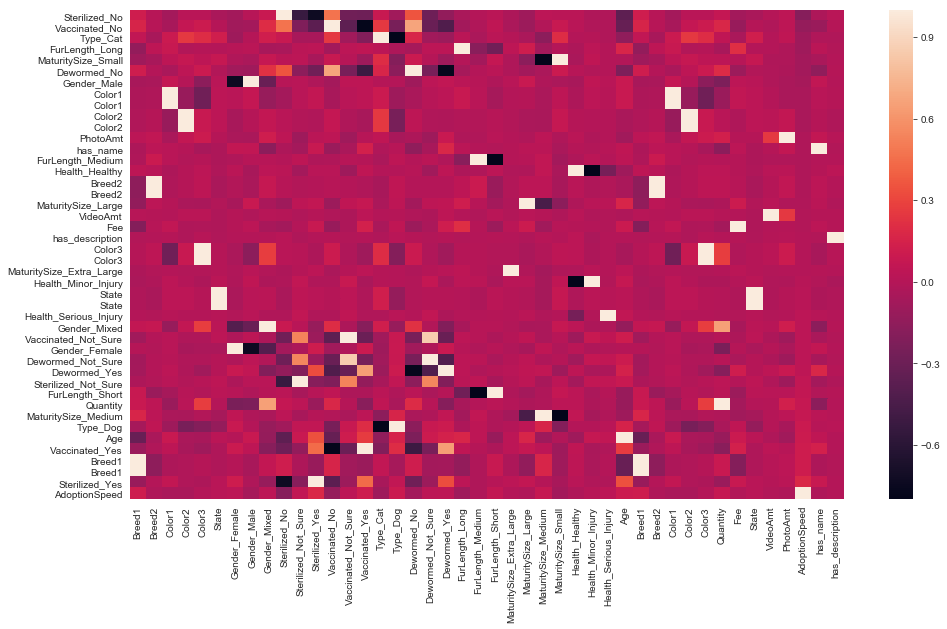

,Breed1,Breed2,Color1,Color2,Color3,State,Gender_Female,Gender_Male,Gender_Mixed,Sterilized_No,...,Color2,Color3,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,has_name,has_description
Sterilized_No,0.12,0.01,-0.06,0.02,0.02,-0.05,-0.07,0.01,0.09,1.00,...,0.02,0.02,0.07,-0.07,-0.05,0.01,0.04,-0.19,-0.03,0.02
Vaccinated_No,0.16,0.01,-0.05,0.07,0.10,0.00,-0.08,-0.07,0.20,0.47,...,0.07,0.10,0.17,-0.12,0.00,-0.01,0.04,-0.13,-0.10,0.01
Type_Cat,0.06,-0.05,0.09,0.25,0.20,0.13,-0.09,0.00,0.12,0.08,...,0.25,0.20,0.05,-0.05,0.13,-0.00,0.05,-0.10,-0.01,-0.02
FurLength_Long,-0.13,0.04,0.08,-0.01,0.01,-0.00,0.01,0.02,-0.05,-0.05,...,-0.01,0.01,-0.05,0.21,-0.00,-0.00,-0.02,-0.09,0.03,-0.01
MaturitySize_Small,-0.09,-0.05,0.04,0.08,0.04,0.07,-0.02,-0.03,0.07,0.02,...,0.08,0.04,0.04,0.01,0.07,-0.02,-0.03,-0.07,-0.05,-0.00
Dewormed_No,0.12,0.00,-0.05,0.04,0.10,-0.01,-0.08,-0.08,0.22,0.35,...,0.04,0.10,0.19,-0.10,-0.01,-0.02,-0.03,-0.07,-0.15,0.00
Gender_Male,-0.05,-0.05,0.07,0.01,-0.16,0.02,-0.74,1.00,-0.31,0.01,...,0.01,-0.16,-0.23,0.03,0.02,-0.02,-0.04,-0.06,0.06,-0.00
Color1,-0.03,-0.02,1.00,-0.11,-0.28,0.03,0.02,0.07,-0.12,-0.06,...,-0.11,-0.28,-0.11,0.06,0.03,0.00,-0.04,-0.05,0.02,0.01
Color1,-0.03,-0.02,1.00,-0.11,-0.28,0.03,0.02,0.07,-0.12,-0.06,...,-0.11,-0.28,-0.11,0.06,0.03,0.00,-0.04,-0.05,0.02,0.01
Color2,-0.01,0.00,-0.11,1.00,0.08,0.03,-0.05,0.01,0.06,0.02,...,1.00,0.08,0.02,-0.02,0.03,0.03,0.06,-0.04,0.00,-0.02


In [260]:

corr_matrix = newdf.corr()
corr_matrix = corr_matrix.sort_values(by='AdoptionSpeed')

plt.figure(figsize=(16,9))
sns.heatmap(corr_matrix, vmin= -0.8)
plt.show()

corr_matrix

In [283]:
# select the columns

less_imp = ['Type_Dog', 'Type_Cat', 'MaturitySize_Extra_Large', 'Health_Serious_Injury']
dummies = dummies.drop(columns = less_imp)

X_columns = ['Age', 'Fee', 'Quantity', 'PhotoAmt','has_name']+ list(dummies.columns)
y_column = ['AdoptionSpeed']

_____________
# Train the Model

In [284]:
# split the data using sklearn

df_train = newdf.copy()

threshold = 0.8
X = df_train[X_columns]
y = df_train[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True, random_state =5)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (8000, 37)
y_train (8000, 1)
X_test (2000, 37)
y_test (2000, 1)


In [285]:
# train a KNN Classifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train.values.ravel())
knn_pred = knn_model.predict(X_test)

In [286]:

rf_model = RandomForestClassifier(150)
rf_model.fit(X_train, y_train.values.ravel())
rf_pred = rf_model.predict(X_test)


In [287]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train.values.ravel())
gnb_pred = gnb_model.predict(X_test)


_____________
# Model Evaluation

In [288]:
knn_kappa = cohen_kappa_score(y_test, knn_pred, weights ='quadratic')
print('kappa', round(knn_kappa, 4))
print(confusion_matrix(y_test, knn_pred))

kappa 0.2271
[[  4  15  16   6   4]
 [ 12 140 132  61  57]
 [  8 163 188  84  86]
 [  9 108 156  99  86]
 [  7 111 133  98 217]]


In [289]:
rf_kappa = cohen_kappa_score(y_test, rf_pred, weights ='quadratic')
print('kappa', round(rf_kappa, 4))
print(confusion_matrix(y_test, rf_pred))

kappa 0.3185
[[  3  14   7   6  15]
 [  3 131 120  67  81]
 [  3 127 186  84 129]
 [  1  67 121 128 141]
 [  0  58 104  51 353]]


In [290]:
gnb_kappa = cohen_kappa_score(y_test, gnb_pred, weights ='quadratic')
print('kappa', round(gnb_kappa, 4))
print(confusion_matrix(y_test, gnb_pred))

kappa 0.2167
[[  4  13   8   6  14]
 [ 22 105 128  55  92]
 [ 22  96 178 104 129]
 [ 27  61 100 132 138]
 [ 17  66 125  76 282]]


In [291]:
# Cross Validation

def cv(model):
    k = 7
    results = []
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        kappa = cohen_kappa_score(y_test, y_pred, weights ='quadratic')
        results.append(round(kappa, 4))

    print('Kappa for each fold:', results)
    print('AVG(kappa)', round(np.mean(results), 4))
    print('STD(kappa)', round(np.std(results), 4))

In [292]:
cv(knn_model)
cv(rf_model)
cv(gnb_model)

Kappa for each fold: [0.2164, 0.2331, 0.188, 0.1929, 0.2461, 0.2196, 0.2124]
AVG(kappa) 0.2155
STD(kappa) 0.0191
Kappa for each fold: [0.3299, 0.3258, 0.3031, 0.2839, 0.3345, 0.2945, 0.3232]
AVG(kappa) 0.3136
STD(kappa) 0.0181
Kappa for each fold: [0.204, 0.2185, 0.2198, 0.2013, 0.2536, 0.1885, 0.2039]
AVG(kappa) 0.2128
STD(kappa) 0.0194


In [293]:

model = rf_model
fi = []

for i, col in enumerate(X_test.columns):
    fi.append([col, model.feature_importances_[i]])
    
pd.DataFrame(fi).sort_values(1, ascending=False)

,0,1
3,PhotoAmt,0.11
0,Age,0.11
6,Breed1,0.05
5,Breed1,0.05
12,Color2,0.04
10,Color1,0.04
9,Color1,0.04
11,Color2,0.04
16,State,0.03
15,State,0.03


__________________
# Submission

In [294]:
X_train = df_train[X_columns]
y_train = df_train[y_column]

df_prediction = newdf_test[X_columns]

In [295]:

rf2_model = RandomForestClassifier(150)
rf2_model.fit(X_train, y_train.values.ravel())
newdf_test['AdoptionSpeed'] = rf2_model.predict(df_prediction)


In [296]:
newdf_test[['PetID', 'AdoptionSpeed']].to_csv('submission_v5.csv', index=False)